<a href="https://colab.research.google.com/github/danielbauer1979/ML_656/blob/main/pa_pynb_sess9_Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning: Clustering and PCA Analysis
Dani Bauer, 2022

As mentioned in the beginning of lecture, there are (at least) two basic learning setups.  In **supervised** machine learning one observes a response $Y$ with observing $p$ different features $X=(X_1,X_2,\ldots,X_p)$, where we typically postulate the relationship $Y = f(X)+\varepsilon$ and $\varepsilon$ independent of $X$ with mean zero. Here quality is usually assessed by the (test/out-of-sample) error that compares predictions and realizations for a separate dataset.  In **unsupervised** learning, we only observe $p$ features $X_1,X_2,\ldots,X_p$, and we would like to learn about their relationship -- without focussing on a supervising outcome.  Of course, the difficulty is how to assess quality in this case -- so different unsupervised learning techniques are very different, and which one to pick will depend on the nature of the problem.

In this tutorial, we will take a closer look at two algorithms: **Principal Component Analysis (PCA)** and **Clustering**.  There are variety of other techniques, including anomaly detection, self-organizing maps, association analysis, etc. We start with quick introductions but then look into the applications of these techniques in more detail in the context of a case study.

As usual, we start by implementing the relevant packages:

In [142]:
import numpy as np 
import matplotlib.pyplot as plt  
import matplotlib.lines as mlines
import plotly.figure_factory as ff
import pandas as pd   
import seaborn as sns
from random import sample

from sklearn.preprocessing import MinMaxScaler, StandardScaler # For rescaling metrics to fit 0 to 1 range
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

# Principal Component Analysis

## Background

The key idea behind *Principal Component Analysis* (PCA) is to use "meaningful" linear combinations of the data:
$$
Z_m = \sum_{j=1}^p \phi_{jm} X_j \text{ such that }\sum_{j=1}^p \phi^2_{jm} = 1,
$$
where the idea is to choose:

- $\phi_{j1},\,j=1,\ldots,p$  such that the the variance of $Z_1$ is maximal (i.e., so that it captures most of the variation in the $X$s)

- $\phi_{j2},\,j=1,\ldots,p$ such that the variance of $Z_2$ is maximial out of all the variables that are uncorrelated with $Z_1$.

- $\phi_{j3},\,j=1,\ldots,p$ such that the variance of $Z_3$ is maximial out of all the variables that are uncorrelated with $Z_1$ and $Z_2$. $\ldots$

Hence, one way to intepret the principal components are the linear combination that best reflect the variation in the data.

Importantly, the scale of variables matters, so it is a good idea to center and scale your variables.  Also, the components are only determined up to their sign (plus/minus).  To discern how important different variables are, one typically considers the *Percent of Variance Explained* (PVE):
$$
\text{PVE}_m = \frac{\sum_{i=1}^n \left(\sum_{j=1}^p \phi_{jm}x_{ij}\right)^2}{\sum_{i=1}^n \sum_{j=1}^p x_{ij}^2},
$$
and the resulting plot that depicts PVE by principal components is referred to as a *scee plot*.

## Simulated Example

Let's consider a basic example, where we simulate heights and weights of a fictional population according to some arbitrary parameters.  More precisely, we assume that weight and height follow Normal distributions with a mean weight (in kg) of 70 and a mean height (in cm) of 170m, and variances of 25 and 150, respectively.  We assume the correlation parameter is 50%.


In [143]:
mu = (70,170)
cov = np.array([[25, np.sqrt(25)*np.sqrt(150)*0.5], [np.sqrt(25)*np.sqrt(150)*0.5, 150]])
X_raw = np.random.multivariate_normal(mu, cov, size=5000)

Let's check quick:

In [144]:
X_raw.mean(axis=0)

array([ 70.09771694, 170.26494615])

In [145]:
np.cov(np.transpose(X_raw))

array([[ 24.50592629,  30.5482845 ],
       [ 30.5482845 , 151.56577393]])

In [146]:
np.corrcoef(np.transpose(X_raw))

array([[1.        , 0.50124574],
       [0.50124574, 1.        ]])

So the *empirical* moments look similar to our theoretical moments. Let's take a peak:


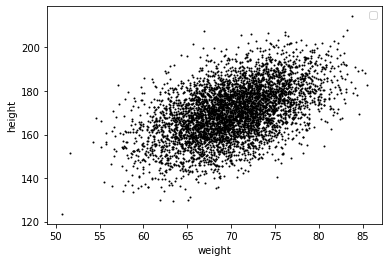

In [147]:
plt.figure(figsize = (6,4))
plt.scatter(X_raw[:,0], X_raw[:,1], s = 1, color = 'black')
plt.xlabel('weight')
plt.ylabel('height')
plt.legend()
plt.show()

Prinicipal components are closely related to the eigen-analysis (eigenvalues and eigenvectors) of the correlation (or covariance) matrix.  Let's illustrate (if you never had a linear algebra class, feel free to skip this part).  First, let's scale the data and calculate the (empirical) correlation matrix -- remember, in practical settings we usually don't know the underlying parameters:


In [148]:
R = np.corrcoef(np.transpose(X_raw))
R

array([[1.        , 0.50124574],
       [0.50124574, 1.        ]])

Let's calculate the eigenvalues and the eigenvectors of `R`.  As a reminder, the eigenvectors decompose a matrix (a.k.a. a linear mapping in finite dimensions) in orthogonal directions, whereas the eignvalues provide the "length" (importance) of the directions.  In particular, we can represent a symmetric matrix in diagnolized form by relying on eigenvectors and eigenvalues. 

In [149]:
Dec = np.linalg.eig(R)
Dec

(array([0.49875426, 1.50124574]), array([[-0.70710678, -0.70710678],
        [ 0.70710678, -0.70710678]]))

In [150]:
V = Dec[1] # Matrix of Eigenvectores
D = np.diag(Dec[0]) # Diagonal Matrix of Eigenvalues
np.dot(np.dot(V,D),np.transpose(V)) # Calculates V * D * V'

array([[1.        , 0.50124574],
       [0.50124574, 1.        ]])

To get intuition, let's plot the Eigenvectors:

<Figure size 432x288 with 0 Axes>

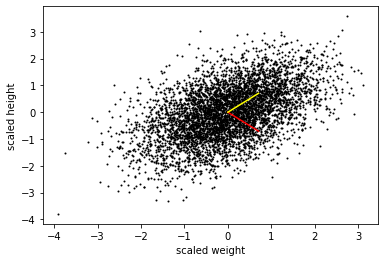

In [151]:
scaler = StandardScaler()
scaler.fit(X_raw)
plt.figure(figsize = (6,4))
fig, ax = plt.subplots()
ax.scatter(scaler.transform(X_raw)[:,0], scaler.transform(X_raw)[:,1], s = 1, color = 'black')
line1 = mlines.Line2D([0, 0.7071], [0, -.7071], color='red')
line2 = mlines.Line2D([0, .7071], [0, .7071], color='yellow')
transform = ax.transAxes
ax.add_line(line1)
ax.add_line(line2)
plt.xlabel('scaled weight')
plt.ylabel('scaled height')
plt.show()

It is exactly this notion of "importance" that motivates principal components.  Indeed, the loadings of the principal components just amount to the *ordered* eigenvalues...

# Clustering

## Background

*Clustering* refers to techniques for finding subgroups in a given dataset. The typical approach to determine clusters $C_1,\ldots,C_K$ is to minimize:
$$
\sum_{k=1}^K W(C_k),
$$
where $W$ is a measure of *variation* within a cluster.  For instance, **k-means clustering** uses the Euclidean distance to measure variation:
$$
W(C_k) = \frac{1}{|C_k|} \sum_{i,i' \in C_k} \sum_{j=1}^p (x_{ij} - x_{i'j})^2.
$$
The algorithms are implemented via a greedy algorithm by considering the centers of clusters (referred to as *centroids*).  The number of clusters $K$ must be chosen beforehand.  One approach is *hierarchical clustering*, where one starts with a larger number of clusters and then *fuses* custers that are similar (e.g., with regards to the distance between their centroids). 

## Simulated Example

Let's consider a very basic simulated example -- let's simulate normal random variables with different means:

In [152]:
X_raw2 = np.random.multivariate_normal((0,0), np.array([[1, 0], [0, 1]]), size=100)
X_raw2[0:49,0]=X_raw2[1:50,0]+3
X_raw2[0:49,1]=X_raw2[1:50,1]-4

Let's plot:

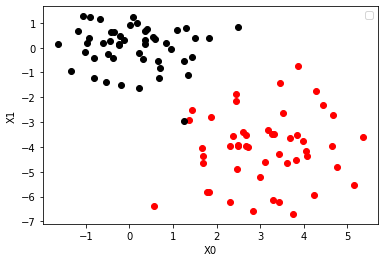

In [153]:
plt.figure(figsize = (6,4))
plt.scatter(X_raw2[0:49,0], X_raw2[0:49,1], color='red')
plt.scatter(X_raw2[50:99,0], X_raw2[50:99,1], color='black')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend()
plt.show()

And let's run k means clustering:


In [154]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 1000, random_state = 123)
kmeans.fit(X_raw2)
centroids = kmeans.cluster_centers_
centroids

array([[ 0.08059452,  0.10909523],
       [ 3.0694002 , -4.0329166 ]])

In [155]:
label = kmeans.fit_predict(X_raw2)
label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

So the algorithm was able to identify how we set up the data!

# Case Study: County Health Rankings 2013

We analyze [County Health Rankings](www.countyhealthrankings.org) in the US in 2013, based on a data set from the University of Wisconsin Population Health Institute.  I took this exammple from Jim Guszcza, and he put this together in R (it's much better than what I had before :-).

## Data Preparation

Let's load the data:

In [156]:
!git clone https://github.com/danielbauer1979/ML_656.git

fatal: destination path 'ML_656' already exists and is not an empty directory.


In [161]:
health = pd.read_csv('ML_656/countyHealthRR.csv')

In [158]:
health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   FIPS                       3141 non-null   int64  
 1   State                      3141 non-null   object 
 2   County                     3141 non-null   object 
 3   YPLL.Rate                  2987 non-null   float64
 4   Perc.Fair.Poor.Health      2743 non-null   float64
 5   Physically.Unhealthy.Days  2897 non-null   float64
 6   Mentally.Unhealthy.Days    2862 non-null   float64
 7   Perc.Low.Birth.Weight      2922 non-null   float64
 8   Perc.Smokers               2536 non-null   float64
 9   Perc.Obese                 3141 non-null   int64  
 10  Perc.Physically.Inactive   3141 non-null   int64  
 11  Perc.Excessive.Drinking    2623 non-null   float64
 12  MV.Mortality.Rate          2773 non-null   float64
 13  Chlamydia.Rate             3135 non-null   float

So it's a large dataset, and the first three numbers are indices.  However, the remaning columns provide rather detailed information for each county.  Let's visualize: 

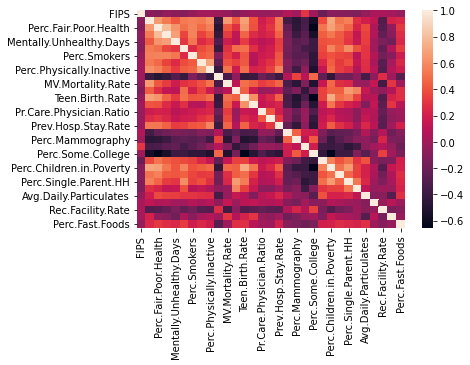

In [159]:
sns.heatmap(health.corr());

So quite a bit of correlation, but nothing seems to be "replicated."  

Unfortunately, we have a bunch of missing data. Let's drop the columns where we have lots of missing values and then drop na-s:

In [162]:
health = health.drop(columns=['FIPS','State','County','Perc.Fair.Poor.Health','Perc.Smokers','Perc.Excessive.Drinking','MV.Mortality.Rate','Pr.Care.Physician.Ratio','Perc.No.Soc.Emo.Support'])

In [163]:
health = health.dropna()

Let's look at the resulting data:

In [164]:
health.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2387 entries, 0 to 3140
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YPLL.Rate                  2387 non-null   float64
 1   Physically.Unhealthy.Days  2387 non-null   float64
 2   Mentally.Unhealthy.Days    2387 non-null   float64
 3   Perc.Low.Birth.Weight      2387 non-null   float64
 4   Perc.Obese                 2387 non-null   int64  
 5   Perc.Physically.Inactive   2387 non-null   int64  
 6   Chlamydia.Rate             2387 non-null   float64
 7   Teen.Birth.Rate            2387 non-null   float64
 8   Perc.Uninsured             2387 non-null   float64
 9   Dentist.Ratio              2387 non-null   float64
 10  Prev.Hosp.Stay.Rate        2387 non-null   float64
 11  Perc.Diabetic.Screening    2387 non-null   float64
 12  Perc.Mammography           2387 non-null   float64
 13  Perc.High.School.Grad      2387 non-null   float

In [165]:
health.describe()

,YPLL.Rate,Physically.Unhealthy.Days,Mentally.Unhealthy.Days,Perc.Low.Birth.Weight,Perc.Obese,Perc.Physically.Inactive,Chlamydia.Rate,Teen.Birth.Rate,Perc.Uninsured,Dentist.Ratio,...,Perc.Some.College,Perc.Unemployed,Perc.Children.in.Poverty,Perc.Single.Parent.HH,Violent.Crime.Rate,Avg.Daily.Particulates,Perc.pop.in.viol,Rec.Facility.Rate,Perc.Limited.Access,Perc.Fast.Foods
count,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000,...,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000
mean,7884.297444,3.807331,3.501718,8.166862,30.431085,27.571429,312.504399,44.272727,17.804776,3190.894847,...,54.485337,8.779263,24.369083,31.188521,281.880603,11.202053,8.605362,8.161500,6.922916,45.810222
std,2215.304596,1.014505,0.935641,1.930727,4.203510,5.290337,236.950701,18.964137,5.172264,1763.230961,...,11.451334,2.770127,8.664314,9.083047,220.443342,1.780946,18.144205,6.379079,5.195984,12.244557
min,2950.000000,1.300000,0.800000,3.400000,14.000000,10.000000,0.000000,4.000000,5.000000,1002.000000,...,23.200000,1.100000,4.000000,4.000000,0.000000,6.400000,0.000000,0.000000,0.000000,7.000000
25%,6278.000000,3.100000,2.900000,6.800000,28.000000,24.000000,157.000000,30.000000,14.000000,1899.500000,...,46.200000,7.000000,18.000000,25.000000,127.500000,9.800000,0.000000,4.000000,3.000000,38.000000
50%,7620.000000,3.700000,3.400000,7.900000,31.000000,28.000000,245.000000,43.000000,18.000000,2703.000000,...,54.500000,8.500000,24.000000,30.000000,224.000000,11.300000,0.000000,7.800000,6.000000,47.000000
75%,9254.000000,4.400000,4.100000,9.200000,33.000000,31.000000,394.000000,57.000000,21.000000,3922.000000,...,62.600000,10.400000,30.000000,36.000000,372.000000,12.700000,7.500000,11.400000,9.000000,54.000000
max,19937.000000,8.500000,7.300000,17.500000,48.000000,44.000000,2245.000000,120.000000,38.000000,9975.000000,...,90.400000,29.700000,62.000000,75.000000,1987.000000,14.800000,100.000000,62.400000,44.000000,100.000000


And let's scale the data so as to make sure we are comparing apples to apples:

In [166]:
scaler = MinMaxScaler()
scaler.fit(health)
health_sc = scaler.transform(health)
health_sc

array([[0.31942073, 0.52777778, 0.53846154, ..., 0.11698718, 0.22727273,
        0.48387097],
       [0.28374639, 0.27777778, 0.46153846, ..., 0.13942308, 0.11363636,
        0.30107527],
       [0.3831165 , 0.51388889, 0.50769231, ..., 0.05929487, 0.25      ,
        0.52688172],
       ...,
       [0.30735268, 0.375     , 0.4       , ..., 0.15224359, 0.15909091,
        0.38709677],
       [0.21369282, 0.22222222, 0.23076923, ..., 0.375     , 0.06818182,
        0.31182796],
       [0.15794431, 0.26388889, 0.33846154, ..., 0.22275641, 0.09090909,
        0.13978495]])

## Clustering

### K-Means clustering

Let's commence with k-means clustering, which is avalable in the library `sklearn.cluster` (along with other clustering algorithms, see below). To decide on the number of clusters, we evaluate how the within-sum-of-squares varies between the number of clusters using a so-called *elbow plot*:


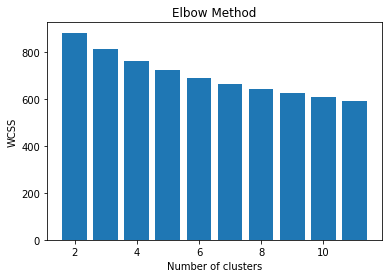

In [167]:
wcss = []
for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(health_sc)
    wcss.append(kmeans.inertia_)
plt.bar(range(2, 12), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

It appears that six clusters seem to present a reasonable choice, there is a bit of an "elbow" there. So let's go with six:

In [168]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=10, random_state=0)
kmeans.fit(health_sc)

KMeans(max_iter=1000, n_clusters=6, random_state=0)

We can get the labels via:

In [169]:
kmeans.labels_

array([1, 1, 2, ..., 3, 3, 3], dtype=int32)

Let's add to our dataset:

In [170]:
health['k_means_cl'] = kmeans.labels_

Let's compare the different clusters by evaluating the YPLL.Rate (Years of Potential Life Lost). 

In [171]:
health[health['k_means_cl'] == 0]['YPLL.Rate'].mean()

5618.843910806175

In [172]:
health[health['k_means_cl'] == 1]['YPLL.Rate'].mean()

7436.093062605753

In [173]:
health[health['k_means_cl'] == 2]['YPLL.Rate'].mean()

10552.69921875

In [174]:
health[health['k_means_cl'] == 3]['YPLL.Rate'].mean()

7698.467849223946

In [175]:
health[health['k_means_cl'] == 4]['YPLL.Rate'].mean()

9982.53638814016

In [176]:
health[health['k_means_cl'] == 5]['YPLL.Rate'].mean()

9424.296296296296

Let's relabel so it's increasing:

In [177]:
def relab(label):
  if label == 0:
    return 0
  elif label == 1:
    return 1
  elif label == 2:
    return 5
  elif label == 3:
    return 2
  elif label == 4:
    return 4
  else:
    return 3

In [178]:
kmlab = list(map(relab, kmeans.labels_))

In [179]:
health['k_means_cl'] = kmlab

### Hierarchical Clustering

Let's use the hierarchical clustering algorithm in scikit (`AgglomerativeClustering`). Plotting a *dendrogram* is easier with the `scipy.cluster.hierarchy`, yet given the size of the dataset we don't see a ton here. 

To compare with the k-means approach, let's run a hierarchical clustering also with six clusters.

In [180]:
hierarch = AgglomerativeClustering(n_clusters=6)
hierarch.fit(health_sc)

AgglomerativeClustering(n_clusters=6)

Again, we can get the labels via:

In [181]:
hierarch.labels_

array([3, 3, 0, ..., 1, 1, 1])

Let's also add to the dataset and carry out a similar approach as before:

In [182]:
health['k_hier_cl'] = hierarch.labels_

In [183]:
health[health['k_hier_cl'] == 0]['YPLL.Rate'].mean()

10747.716763005781

In [184]:
health[health['k_hier_cl'] == 1]['YPLL.Rate'].mean()

8133.551526717557

In [185]:
health[health['k_hier_cl'] == 2]['YPLL.Rate'].mean()

5637.884782608696

In [186]:
health[health['k_hier_cl'] == 3]['YPLL.Rate'].mean()

8358.641025641025

In [187]:
health[health['k_hier_cl'] == 4]['YPLL.Rate'].mean()

8356.783783783783

In [188]:
health[health['k_hier_cl'] == 5]['YPLL.Rate'].mean()

6744.8328767123285

In [189]:
def relab2(label):
  if label == 0:
    return 5
  elif label == 1:
    return 2
  elif label == 2:
    return 0
  elif label == 3:
    return 4
  elif label == 4:
    return 3
  else:
    return 1

In [190]:
hierlab = list(map(relab2, hierarch.labels_))

In [191]:
health['k_hier_cl'] = hierlab 

Let's compare the two:

In [192]:
labels = [0,1,2,3,4,5]
confusion_matrix(health['k_means_cl'],health['k_hier_cl'],labels=labels)

array([[423,  99,  22,  35,   4,   0],
       [  3, 229,  32,  11, 313,   3],
       [ 34,  28, 364,  12,  13,   0],
       [  0,   0,  11, 115,   1,   8],
       [  0,   0,  65,  10, 160, 136],
       [  0,   9,  30,   2,  16, 199]])

So it looks like there is quite a bit of overlap, particularly with regards to clusters 0, 1, and 2. It appears clusters 4 and 5 are overlapping. However, it also is clear that assigning points to clusters isn't highly obvious.

### Visualizing Clusters

Let's visualize clusters by comparing the distributions of some of the features across clusters. As we had discussed, comparing distributions can be conveniently accomplished via box-whisker plots.

Let's start with children in poverty.

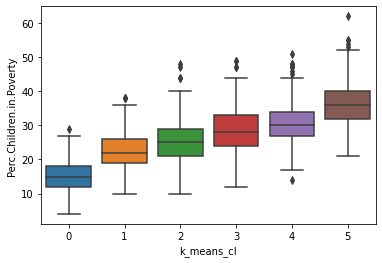

In [194]:
sns.boxplot(x = "k_means_cl", y = "Perc.Children.in.Poverty", data = health)
plt.show()

Recall that we sorted the clusters according to YPLL.Rate (Years of Potential Life Lost), so more years of life lost is a sign of worse health. It appears that this weakly aligns with children poverty.

Let's look at violent crimes.

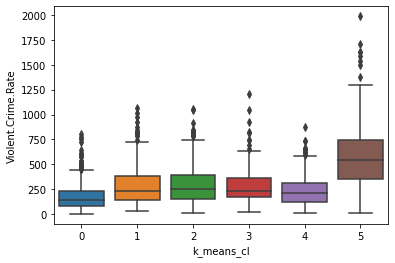

In [195]:
sns.boxplot(x = "k_means_cl", y = "Violent.Crime.Rate", data = health)
plt.show()

So here we have a weak alignment, although cluster 4 seems a bit lower. Let's look at fast food concentration.

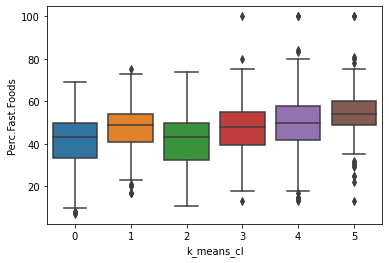

In [196]:
sns.boxplot(x = "k_means_cl", y = "Perc.Fast.Foods", data = health)
plt.show()